# Wyznaczanie wierzchołków pasm materiałów na podłożu GaSb:

Materiał: GaAlSb  
Podłoże: GaSb

### Load material:

In [32]:
#material = 'GaAlGeSb'
material = 'GaAlSb'
ground_material = 'GaSb'

In [97]:
import re

component_names = re.findall('[A-Z][^A-Z]*', material) 
print("Components: ", component_names)

Components:  ['Ga', 'Al', 'Sb']


In [72]:
import re
from mendeleev import element
from collections import Counter

def material_type_checker(material):
    component_names = re.findall('[A-Z][^A-Z]*', material) 
    
    components = [element(c_name) for c_name in component_names]

    group_counter = Counter([c.group.symbol for c in components])
    
    material_type_extensive = [f'{group}_{numbers}' for group, numbers in zip(group_counter.keys(), group_counter.values())]
    material_type_extensive = "_".join(material_type_extensive)

    material_type = list(group_counter.keys())
    material_type = "_".join(material_type)
    
    return material_type, material_type_extensive

material_type, material_type_extensive = material_type_checker(material)

print("Material type:", material_type)
print("Material type extensive:", material_type_extensive)

Components:  ['Ga', 'Al', 'Sb']
Material type: IIIA_VA
Material type extensive: IIIA_2_VA_1


In [86]:
from src.utils import roman_to_int

def two_componens_decomposition(material):
    component_names = re.findall('[A-Z][^A-Z]*', material) 

    components = [element(c_name) for c_name in component_names]
    group_symbols = [c.group.symbol for c in components]
    group_ids = [c.group_id for c in components]

    group_counter = Counter(group_ids)
    # go through all groups counter if there is more than 1 component from the same group. 
    # That mean we have mixture of a two components in semiconductor
    for group, n in group_counter.items():
        if n>1:
            # if there is, we need to collect all components from same group
            base_compounds = []
            for (comp, comp_group) in zip(component_names, group_ids):
                if comp_group==group:
                    base_compounds.append(comp)
            
            # then we need to assign to them rest of the elements from other groups
            two_components = []
            for (comp, comp_group) in zip(component_names, group_ids):
                if comp_group!=group:
                    for base in base_compounds:
                        # if the base element is from earlier group we need to assign it first in the name:
                        if group<=comp_group:
                            two_components.append(base+comp)
                        # if otherwise, we need to assign it at the end:
                        if group>comp_group:
                            two_components.append(comp+base)
    
    return two_components
            
    
two_components = two_componens_decomposition(material)
two_components

['GaSb', 'AlSb']

## Energy band characteristics:

### Band gaps in temperature of `300K` from mole fraction:

Read band gaps in `T=300K`:

In [85]:
import os


def param_reader(components, params_file_path, param):
    read_params = []
    for c in components:
        with open(os.path.join(params_file_path, c+".txt")) as f:
            lines = f.readlines()
            for line in lines:
                if line.split("=")[0]==param:
                    read_param_str = line.split("=")[1].split(" ")[0]
                    read_param_float = float(read_param_str)
                    read_params.append(read_param_float)

    return read_params

params_file_path = os.path.join(".", "materials")
param ='Eg_300K'
band_gaps = param_reader(two_components, params_file_path, param)
band_gaps

[0.68, 1.58]

Import simulation method:

In [87]:
import importlib

try:
    libname = ".".join(["src", "simulations", material_type])
    simulation = importlib.import_module(libname)
    simulation = importlib.reload(simulation)
except ImportError:
    simulation = None
    print(f'Simulation method for \'{material_type}\' not implemented.')
else:
    globals()[libname] = simulation

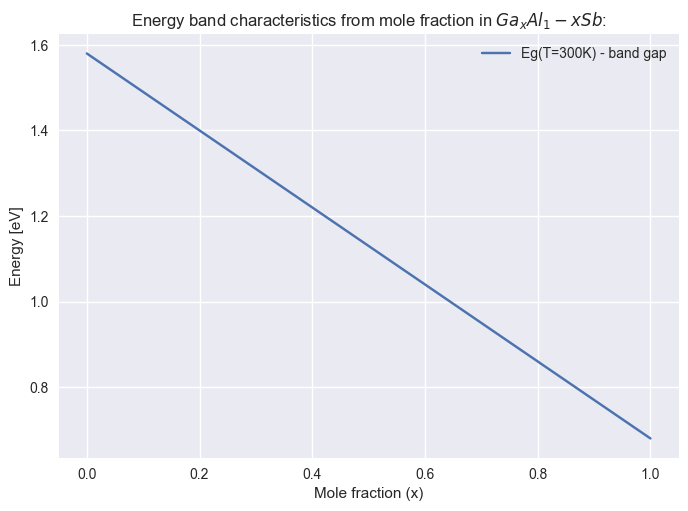

In [116]:
import matplotlib.pyplot as plt

x, Eg_x = simulation.band_gap_from_mole_fraction(band_gaps, material_type_extensive, method="VCA", points=11)

with plt.style.context("seaborn"):
    plt.plot(x, Eg_x, '-', label='Eg(T=300K) - band gap')
    plt.title(r'Energy band characteristics from mole fraction in ${}_x{}_{a}{}$:'.format(*component_names, a="1-x"))
    plt.ylabel("Energy [eV]")
    plt.xlabel("Mole fraction (x)")
    plt.legend()
    plt.show()